# Project 3:  Implement SLAM 

---

## Project Overview

In this project, you'll implement SLAM for robot that moves and senses in a 2 dimensional, grid world!

SLAM gives us a way to both localize a robot and build up a map of its environment as a robot moves and senses in real-time. This is an active area of research in the fields of robotics and autonomous systems. Since this localization and map-building relies on the visual sensing of landmarks, this is a computer vision problem. 

Using what you've learned about robot motion, representations of uncertainty in motion and sensing, and localization techniques, you will be tasked with defining a function, `slam`, which takes in six parameters as input and returns the vector `mu`. 
> `mu` contains the (x,y) coordinate locations of the robot as it moves, and the positions of landmarks that it senses in the world

You can implement helper functions as you see fit, but your function must return `mu`. The vector, `mu`, should have (x, y) coordinates interlaced, for example, if there were 2 poses and 2 landmarks, `mu` will look like the following, where `P` is the robot position and `L` the landmark position:
```
mu =  matrix([[Px0],
              [Py0],
              [Px1],
              [Py1],
              [Lx0],
              [Ly0],
              [Lx1],
              [Ly1]])
```

You can see that `mu` holds the poses first `(x0, y0), (x1, y1), ...,` then the landmark locations at the end of the matrix; we consider a `nx1` matrix to be a vector.

## Generating an environment

In a real SLAM problem, you may be given a map that contains information about landmark locations, and in this example, we will make our own data using the `make_data` function, which generates a world grid with landmarks in it and then generates data by placing a robot in that world and moving and sensing over some numer of time steps. The `make_data` function relies on a correct implementation of robot move/sense functions, which, at this point, should be complete and in the `robot_class.py` file. The data is collected as an instantiated robot moves and senses in a world. Your SLAM function will take in this data as input. So, let's first create this data and explore how it represents the movement and sensor measurements that our robot takes.

---

## Create the world

Use the code below to generate a world of a specified size with randomly generated landmark locations. You can change these parameters and see how your implementation of SLAM responds! 

`data` holds the sensors measurements and motion of your robot over time. It stores the measurements as `data[i][0]` and the motion as `data[i][1]`.

#### Helper functions

You will be working with the `robot` class that may look familiar from the first notebook, 

In fact, in the `helpers.py` file, you can read the details of how data is made with the `make_data` function. It should look very similar to the robot move/sense cycle you've seen in the first notebook.

In [21]:
# Import libraries
import numpy as np
from helpers import make_data
# your implementation of slam should work with the following inputs
# feel free to change these input values and see how it responds!
# world parameters

num_landmarks      = 5        # number of landmarks
N                  = 20       # time steps
world_size         = 100.0    # size of world (square)

# robot parameters
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation 

# make_data instantiates a robot, AND generates random landmarks for a given world size and number of landmarks
data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)


 
Landmarks:  [[7, 7], [62, 54], [29, 7], [73, 54], [78, 72]]
Robot: [x=92.64210 y=34.09460]


### A note on `make_data`

The function above, `make_data`, takes in so many world and robot motion/sensor parameters because it is responsible for:
1. Instantiating a robot (using the robot class)
2. Creating a grid world with landmarks in it

**This function also prints out the true location of landmarks and the *final* robot location, which you should refer back to when you test your implementation of SLAM.**

The `data` this returns is an array that holds information about **robot sensor measurements** and **robot motion** `(dx, dy)` that is collected over a number of time steps, `N`. You will have to use *only* these readings about motion and measurements to track a robot over time and find the determine the location of the landmarks using SLAM. We only print out the true landmark locations for comparison, later.


In `data` the measurement and motion data can be accessed from the first and second index in the columns of the data array. See the following code for an example, where `i` is the time step:
```
measurement = data[i][0]
motion = data[i][1]
```


In [32]:
# print out some stats about the data
time_step = 16

print('Example measurements: \n', data[time_step][0])
print('\n')
print('Example motion: \n', data[time_step][1])

Example measurements: 
 [[0, -52.7131754741133, -35.16623373546266], [1, 2.6496521985131762, 12.196593937163815], [2, -30.109697735872537, -34.5627559972219], [3, 11.678376048275744, 10.225317786926382], [4, 16.52514793269712, 28.072089671347758]]


Example motion: 
 [15.421930934491456, -12.734364776139229]


Try changing the value of `time_step`, you should see that the list of measurements varies based on what in the world the robot sees after it moves. As you know from the first notebook, the robot can only sense so far and with a certain amount of accuracy in the measure of distance between its location and the location of landmarks. The motion of the robot always is a vector with two values: one for x and one for y displacement. This structure will be useful to keep in mind as you traverse this data in your implementation of slam.

## Initialize Constraints

One of the most challenging tasks here will be to create and modify the constraint matrix and vector: omega and xi. In the second notebook, you saw an example of how omega and xi could hold all the values the define the relationships between robot poses `xi` and landmark positions `Li` in a 1D world, as seen below, where omega is the blue matrix and xi is the pink vector.

<img src='images/motion_constraint.png' width=50% height=50% />


In *this* project, you are tasked with implementing constraints for a 2D world. We are referring to robot poses as `Px, Py` and landmark positions as `Lx, Ly`, and one way to approach this challenge is to add *both* x and y locations in the constraint matrices.

<img src='images/constraints2D.png' width=50% height=50% />

You may also choose to create two of each omega and xi (one for x and one for y positions).

### TODO: Write a function that initializes omega and xi

Complete the function `initialize_constraints` so that it returns `omega` and `xi` constraints for the starting position of the robot. Any values that we do not yet know should be initialized with the value `0`. You may assume that our robot starts out in exactly the middle of the world with 100% confidence (no motion or measurement noise at this point). The inputs `N` time steps, `num_landmarks`, and `world_size` should give you all the information you need to construct intial constraints of the correct size and starting values.

*Depending on your approach you may choose to return one omega and one xi that hold all (x,y) positions *or* two of each (one for x values and one for y); choose whichever makes most sense to you!*

In [43]:
def initialize_constraints(N, num_landmarks, world_size):
    ''' This function takes in a number of time steps N, number of landmarks, and a world_size,
        and returns initialized constraint matrices, omega and xi.'''
    ## Recommended: Define and store the size (rows/cols) of the constraint matrix in a variable
    ## TODO: Define the constraint matrix, Omega, with two initial "strength" values
    ## for the initial x, y location of our robot
    rows, cols = 2 * (N + num_landmarks), 2 * (N + num_landmarks )
    
    # create omega with a matrix of zeros
    omega = np.zeros((rows, cols))
    idx_z = 0
    idx_o = 1
    omega[idx_z][idx_z] = 1
    omega[idx_o][idx_o] = 1
    
    ## TODO: Define the constraint *vector*, xi
    ## you can assume that the robot starts out in the middle of the world with 100% confidence
    # create xi with a matrix of zeros
    # set robot initial position in the middle of the world
    xi = np.zeros((rows, 1))
    xi[0][0], xi[1][0] = world_size/2, world_size/2
    
    return omega, xi

### Test as you go

It's good practice to test out your code, as you go. Since `slam` relies on creating and updating constraint matrices, `omega` and `xi` to account for robot sensor measurements and motion, let's check that they initialize as expected for any given parameters.

Below, you'll find some test code that allows you to visualize the results of your function `initialize_constraints`. We are using the [seaborn](https://seaborn.pydata.org/) library for visualization.

**Please change the test values of N, landmarks, and world_size and see the results**. Be careful not to use these values as input into your final smal function.

This code assumes that you have created one of each constraint: `omega` and `xi`, but you can change and add to this code, accordingly. The constraints should vary in size with the number of time steps and landmarks as these values affect the number of poses a robot will take `(Px0,Py0,...Pxn,Pyn)` and landmark locations `(Lx0,Ly0,...Lxn,Lyn)` whose relationships should be tracked in the constraint matrices. Recall that `omega` holds the weights of each variable and `xi` holds the value of the sum of these variables, as seen in Notebook 2. You'll need the `world_size` to determine the starting pose of the robot in the world and fill in the initial values for `xi`.

In [34]:
# import libraries to process and visualize data

import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

In [44]:
# define a small N and world_size

N_test = 6
num_landmarks_test = 3
small_world = 13

# initialize the constraints
initial_omega, initial_xi = initialize_constraints(N_test, num_landmarks_test, small_world)

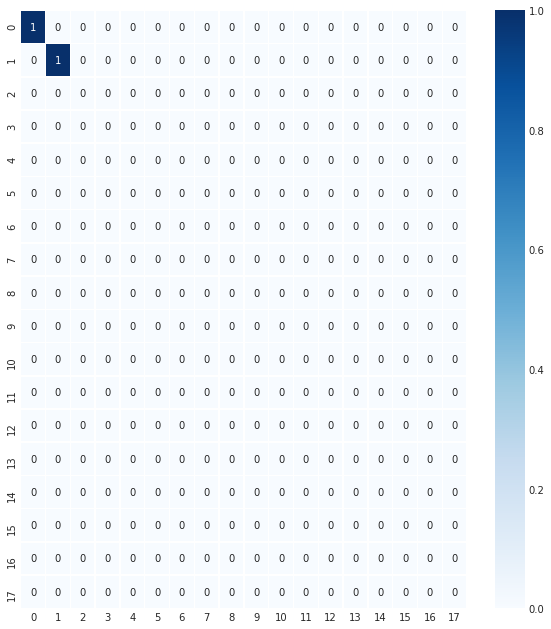

In [47]:
# define figure size
plt.rcParams["figure.figsize"] = (10, 11)

# display omega
sns.heatmap(DataFrame(initial_omega), cmap='Blues', annot=True, linewidths=.5)

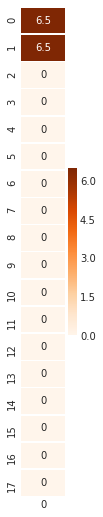

In [48]:
# defining figure size

plt.rcParams["figure.figsize"] = (1, 9)

# display xi
sns.heatmap(DataFrame(initial_xi), cmap='Oranges', annot=True, linewidths=.5)

---
## SLAM inputs 

In addition to `data`, your slam function will also take in:
* N -   The number of time steps that a robot will be moving and sensing
* num_landmarks - The number of landmarks in the world
* world_size - The size (w/h) of your world
* motion_noise - The noise associated with motion; the update confidence for motion should be `1.0/motion_noise`
* measurement_noise - The noise associated with measurement/sensing; the update weight for measurement should be `1.0/measurement_noise`

#### A note on noise

Recall that `omega` holds the relative "strengths" or weights for each position variable, and you can update these weights by accessing the correct index in omega `omega[row][col]` and *adding/subtracting* `1.0/noise` where `noise` is measurement or motion noise. `Xi` holds actual position values, and so to update `xi` you'll do a similar addition process only using the actual value of a motion or measurement. So for a vector index `xi[row][0]` you will end up adding/subtracting one measurement or motion divided by their respective `noise`.

### TODO: Implement Graph SLAM

Follow the TODO's below to help you complete this slam implementation (these TODO's are in the recommended order), then test out your implementation! 

#### Updating with motion and measurements

With a 2D omega and xi structure as shown above (in earlier cells), you'll have to be mindful about how you update the values in these constraint matrices to account for motion and measurement constraints in the x and y directions. Recall that the solution to these matrices (which holds all values for robot poses `P` and landmark locations `L`) is the vector, `mu`, which can be computed at the end of the construction of omega and xi as the inverse of omega times xi: $\mu = \Omega^{-1}\xi$

**You may also choose to return the values of `omega` and `xi` if you want to visualize their final state!**

In [50]:
## TODO: Complete the code to implement SLAM
## slam takes in 6 arguments and returns mu, 
## mu is the entire path traversed by a robot (all x,y poses) *and* all landmarks locations
def slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise):
    ## TODO: Use your initilization to create constraint matrices, omega and xi
    ## TODO: Iterate through each time step in the data
    ## get all the motion and measurement data as you iterate
    # measurement noise weight
    
    omega, xi = initialize_constraints(N, num_landmarks, world_size)
    mtn_w = 1 / measurement_noise
    
    for i in range(len(data)):
        # get measurements and motion from data
        # position, for x & y
        measurements, motion = data[i][0], data[i][1]
        pos = 2*i
            
    ## TODO: update the constraint matrix/vector to account for all *measurements*
    ## this should be a series of additions that take into account the measurement noise
        for measure in measurements:
            idx_landmark = 2 * (N + measure[0])
            x, y = measure[1], measure[2]
            
            # loop through for x and y for omega
            for j in range(2):
                omega[pos + j] [pos + j] += mtn_w
                omega[idx_landmark + j][idx_landmark + j] += mtn_w
                omega[pos + j][idx_landmark + j] += -mtn_w
                omega[idx_landmark + j][pos + j] += -mtn_w
            
            # xi x, y
            xi[pos,0] += -x*mtn_w
            xi[idx_landmark, 0] += x*mtn_w
            xi[pos+1,0] += -y*mtn_w
            xi[idx_landmark+1, 0] += y*mtn_w
            
    ## TODO: update the constraint matrix/vector to account for all *motion* and motion noise
        # motion noise weight
        mtn_w = 1 / motion_noise
        
        # loop through x and y for omega and xi
        for j in range(2):
            omega[pos + j][pos + j] += mtn_w
            omega[pos + 2 + j][pos + 2 +j] += mtn_w
            omega[pos + 2 + j][pos + j] += -mtn_w
            omega[pos + j][pos + 2 + j] += -mtn_w
            xi[pos + j][0] += -motion[j]/motion_noise
            xi[pos + 2 + j][0] += motion[j]/motion_noise  
            
    ## TODO: After iterating through all the data
    ## Compute the best estimate of poses and landmark positions
    ## using the formula, omega_inverse * Xi
    omega_inv = np.linalg.inv(np.matrix(omega))
    mu = omega_inv * xi
    
    return mu

## Helper functions

To check that your implementation of SLAM works for various inputs, we have provided two helper functions that will help display the estimated pose and landmark locations that your function has produced. First, given a result `mu` and number of time steps, `N`, we define a function that extracts the poses and landmarks locations and returns those as their own, separate lists. 

Then, we define a function that nicely print out these lists; both of these we will call, in the next step.


In [51]:
# a helper function that creates a list of poses and of landmarks for ease of printing
# this only works for the suggested constraint architecture of interlaced x,y poses
def get_poses_landmarks(mu, N):
    # create a list of poses
    poses = []
    for i in range(N):
        poses.append((mu[2*i].item(), mu[2*i+1].item()))

    # create a list of landmarks
    landmarks = []
    for i in range(num_landmarks):
        landmarks.append((mu[2*(N+i)].item(), mu[2*(N+i)+1].item()))

    # return completed lists
    return poses, landmarks

In [52]:
def print_all(poses, landmarks):
    print('\n')
    print('Estimated Poses:')
    for i in range(len(poses)):
        print('['+', '.join('%.3f'%p for p in poses[i])+']')
    print('\n')
    print('Estimated Landmarks:')
    for i in range(len(landmarks)):
        print('['+', '.join('%.3f'%l for l in landmarks[i])+']')

## Run SLAM

Once you've completed your implementation of `slam`, see what `mu` it returns for different world sizes and different landmarks!

### What to Expect

The `data` that is generated is random, but you did specify the number, `N`, or time steps that the robot was expected to move and the `num_landmarks` in the world (which your implementation of `slam` should see and estimate a position for. Your robot should also start with an estimated pose in the very center of your square world, whose size is defined by `world_size`.

With these values in mind, you should expect to see a result that displays two lists:
1. **Estimated poses**, a list of (x, y) pairs that is exactly `N` in length since this is how many motions your robot has taken. The very first pose should be the center of your world, i.e. `[50.000, 50.000]` for a world that is 100.0 in square size.
2. **Estimated landmarks**, a list of landmark positions (x, y) that is exactly `num_landmarks` in length. 

#### Landmark Locations

If you refer back to the printout of *exact* landmark locations when this data was created, you should see values that are very similar to those coordinates, but not quite (since `slam` must account for noise in motion and measurement).

In [53]:
# call your implementation of slam, passing in the necessary parameters
mu = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)

# print out the resulting landmarks and poses
if(mu is not None):
    # get the lists of poses and landmarks
    # and print them out
    poses, landmarks = get_poses_landmarks(mu, N)
    print_all(poses, landmarks)



Estimated Poses:
[50.000, 50.000]
[69.289, 59.540]
[87.947, 68.958]
[72.775, 82.924]
[56.419, 95.663]
[77.373, 95.258]
[95.723, 93.620]
[77.369, 89.410]
[59.770, 84.567]
[41.067, 78.595]
[20.678, 74.681]
[1.535, 71.076]
[0.827, 91.141]
[14.850, 78.485]
[28.833, 65.643]
[42.929, 52.825]
[59.622, 42.118]
[74.322, 29.291]
[89.893, 15.924]
[93.980, 35.501]


Estimated Landmarks:
[7.068, 7.141]
[61.708, 53.762]
[28.883, 6.957]
[72.951, 54.028]
[77.526, 71.589]


## Visualize the constructed world

Finally, using the `display_world` code from the `helpers.py` file (which was also used in the first notebook), we can actually visualize what you have coded with `slam`: the final position of the robot and the positon of landmarks, created from only motion and measurement data!

**Note that these should be very similar to the printed *true* landmark locations and final pose from our call to `make_data` early in this notebook.**

Last pose:  (93.98026718595554, 35.50144087247897)


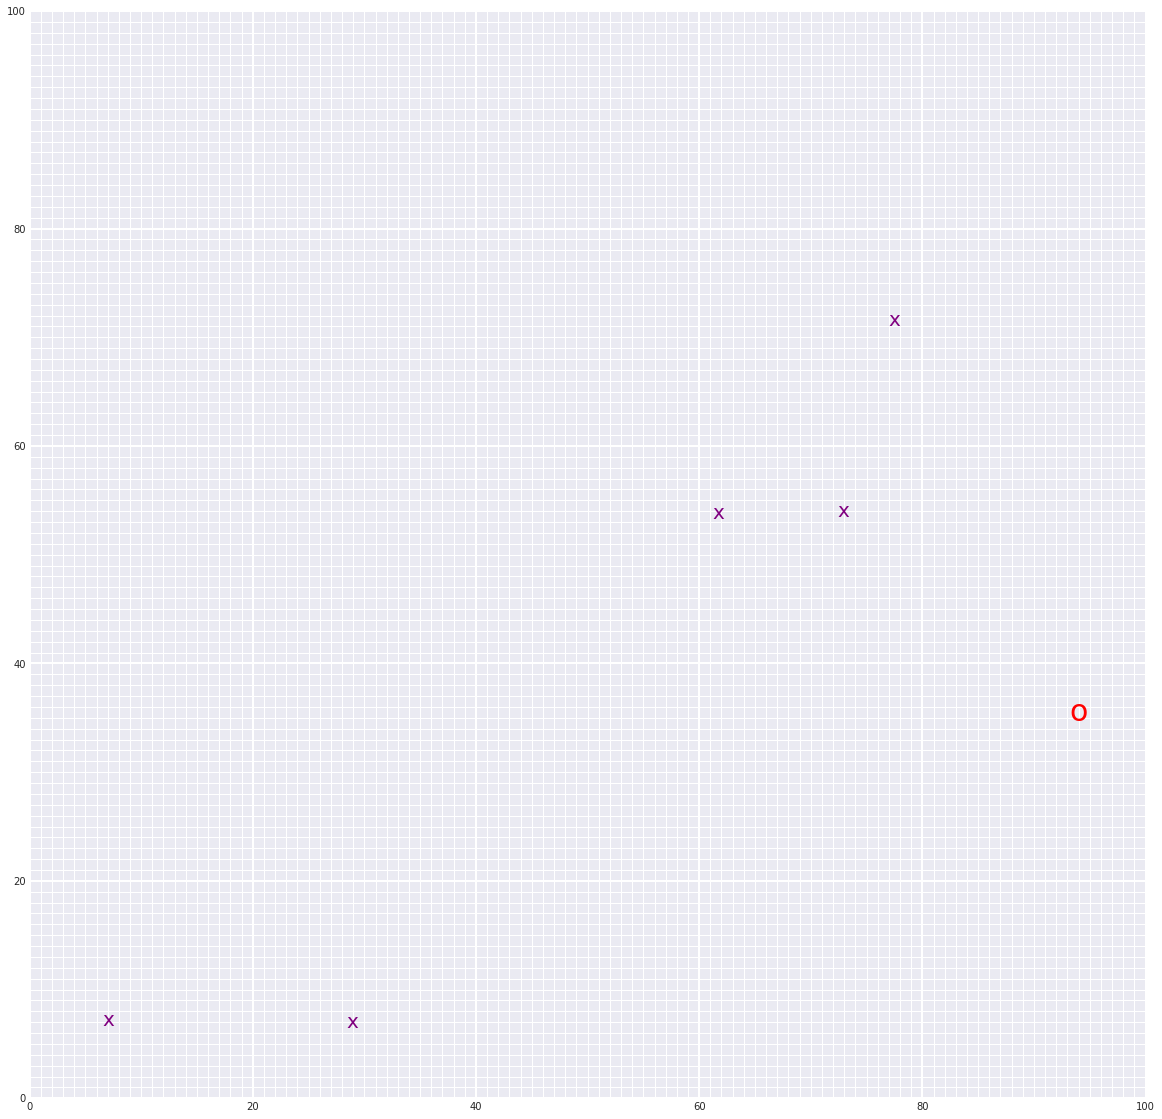

In [54]:
# import the helper function
from helpers import display_world

# Display the final world!

# define figure size
plt.rcParams["figure.figsize"] = (20,20)

# check if poses has been created
if 'poses' in locals():
    # print out the last pose
    print('Last pose: ', poses[-1])
    # display the last position of the robot *and* the landmark positions
    display_world(int(world_size), poses[-1], landmarks)

### Question: How far away is your final pose (as estimated by `slam`) compared to the *true* final pose? Why do you think these poses are different?

You can find the true value of the final pose in one of the first cells where `make_data` was called. You may also want to look at the true landmark locations and compare them to those that were estimated by `slam`. Ask yourself: what do you think would happen if we moved and sensed more (increased N)? Or if we had lower/higher noise parameters.

**Answer**: (Write your answer here.)

From the results of the final pose i got this value, Robot: [x=92.64210 y=34.09460]

The final pose from SLAM, [93.980, 35.501]: 

Apparently I can see a miniscule difference when comparing the first final pose compared to the SLAM estimated pose. The offset in value could be due to the noise from the measurement and the motion pose which could be under or over estimated by the observer.

To reduce the noise further thus, make the noise negligible getting more datapoints by means of navigating more.

## Testing

To confirm that your slam code works before submitting your project, it is suggested that you run it on some test data and cases. A few such cases have been provided for you, in the cells below. When you are ready, uncomment the test cases in the next cells (there are two test cases, total); your output should be **close-to or exactly** identical to the given results. If there are minor discrepancies it could be a matter of floating point accuracy or in the calculation of the inverse matrix.

### Submit your project

If you pass these tests, it is a good indication that your project will pass all the specifications in the project rubric. Follow the submission instructions to officially submit!

In [57]:
# Here is the data and estimated outputs for test case 1

test_data1 = [[[[1, 19.457599255548065, 23.8387362100849], [2, -13.195807561967236, 11.708840328458608], [3, -30.0954905279171, 15.387879242505843]], [-12.2607279422326, -15.801093326936487]], [[[2, -0.4659930049620491, 28.088559771215664], [4, -17.866382374890936, -16.384904503932]], [-12.2607279422326, -15.801093326936487]], [[[4, -6.202512900833806, -1.823403210274639]], [-12.2607279422326, -15.801093326936487]], [[[4, 7.412136480918645, 15.388585962142429]], [14.008259661173426, 14.274756084260822]], [[[4, -7.526138813444998, -0.4563942429717849]], [14.008259661173426, 14.274756084260822]], [[[2, -6.299793150150058, 29.047830407717623], [4, -21.93551130411791, -13.21956810989039]], [14.008259661173426, 14.274756084260822]], [[[1, 15.796300959032276, 30.65769689694247], [2, -18.64370821983482, 17.380022987031367]], [14.008259661173426, 14.274756084260822]], [[[1, 0.40311325410337906, 14.169429532679855], [2, -35.069349468466235, 2.4945558982439957]], [14.008259661173426, 14.274756084260822]], [[[1, -16.71340983241936, -2.777000269543834]], [-11.006096015782283, 16.699276945166858]], [[[1, -3.611096830835776, -17.954019226763958]], [-19.693482634035977, 3.488085684573048]], [[[1, 18.398273354362416, -22.705102332550947]], [-19.693482634035977, 3.488085684573048]], [[[2, 2.789312482883833, -39.73720193121324]], [12.849049222879723, -15.326510824972983]], [[[1, 21.26897046581808, -10.121029799040915], [2, -11.917698965880655, -23.17711662602097], [3, -31.81167947898398, -16.7985673023331]], [12.849049222879723, -15.326510824972983]], [[[1, 10.48157743234859, 5.692957082575485], [2, -22.31488473554935, -5.389184118551409], [3, -40.81803984305378, -2.4703329790238118]], [12.849049222879723, -15.326510824972983]], [[[0, 10.591050242096598, -39.2051798967113], [1, -3.5675572049297553, 22.849456408289125], [2, -38.39251065320351, 7.288990306029511]], [12.849049222879723, -15.326510824972983]], [[[0, -3.6225556479370766, -25.58006865235512]], [-7.8874682868419965, -18.379005523261092]], [[[0, 1.9784503557879374, -6.5025974151499]], [-7.8874682868419965, -18.379005523261092]], [[[0, 10.050665232782423, 11.026385307998742]], [-17.82919359778298, 9.062000642947142]], [[[0, 26.526838150174818, -0.22563393232425621], [4, -33.70303936886652, 2.880339841013677]], [-17.82919359778298, 9.062000642947142]]]

##  Test Case 1
##
# Estimated Pose(s):
#     [50.000, 50.000]
#     [37.858, 33.921]
#     [25.905, 18.268]
#     [13.524, 2.224]
#     [27.912, 16.886]
#     [42.250, 30.994]
#     [55.992, 44.886]
#     [70.749, 59.867]
#     [85.371, 75.230]
#     [73.831, 92.354]
#     [53.406, 96.465]
#     [34.370, 100.134]
#     [48.346, 83.952]
#     [60.494, 68.338]
#     [73.648, 53.082]
#     [86.733, 38.197]
#     [79.983, 20.324]
#     [72.515, 2.837]
#     [54.993, 13.221]
#     [37.164, 22.283]


# Estimated Landmarks:
#     [82.679, 13.435]
#     [70.417, 74.203]
#     [36.688, 61.431]
#     [18.705, 66.136]
#     [20.437, 16.983]


### Uncomment the following three lines for test case 1 and compare the output to the values above ###

mu_1 = slam(test_data1, 20, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_1, 20)
print_all(poses, landmarks)



Estimated Poses:
[50.000, 50.000]
[37.973, 33.652]
[26.185, 18.155]
[13.745, 2.116]
[28.097, 16.783]
[42.384, 30.902]
[55.831, 44.497]
[70.857, 59.699]
[85.697, 75.543]
[74.011, 92.434]
[53.544, 96.454]
[34.525, 100.080]
[48.623, 83.953]
[60.197, 68.107]
[73.778, 52.935]
[87.132, 38.538]
[80.303, 20.508]
[72.798, 2.945]
[55.245, 13.255]
[37.416, 22.317]


Estimated Landmarks:
[82.956, 13.539]
[70.495, 74.141]
[36.740, 61.281]
[18.698, 66.060]
[20.635, 16.875]


In [58]:
# Here is the data and estimated outputs for test case 2

test_data2 = [[[[0, 26.543274387283322, -6.262538160312672], [3, 9.937396825799755, -9.128540360867689]], [18.92765331253674, -6.460955043986683]], [[[0, 7.706544739722961, -3.758467215445748], [1, 17.03954411948937, 31.705489938553438], [3, -11.61731288777497, -6.64964096716416]], [18.92765331253674, -6.460955043986683]], [[[0, -12.35130507136378, 2.585119104239249], [1, -2.563534536165313, 38.22159657838369], [3, -26.961236804740935, -0.4802312626141525]], [-11.167066095509824, 16.592065417497455]], [[[0, 1.4138633151721272, -13.912454837810632], [1, 8.087721200818589, 20.51845934354381], [3, -17.091723454402302, -16.521500551709707], [4, -7.414211721400232, 38.09191602674439]], [-11.167066095509824, 16.592065417497455]], [[[0, 12.886743222179561, -28.703968411636318], [1, 21.660953298391387, 3.4912891084614914], [3, -6.401401414569506, -32.321583037341625], [4, 5.034079343639034, 23.102207946092893]], [-11.167066095509824, 16.592065417497455]], [[[1, 31.126317672358578, -10.036784369535214], [2, -38.70878528420893, 7.4987265861424595], [4, 17.977218575473767, 6.150889254289742]], [-6.595520680493778, -18.88118393939265]], [[[1, 41.82460922922086, 7.847527392202475], [3, 15.711709540417502, -30.34633659912818]], [-6.595520680493778, -18.88118393939265]], [[[0, 40.18454208294434, -6.710999804403755], [3, 23.019508919299156, -10.12110867290604]], [-6.595520680493778, -18.88118393939265]], [[[3, 27.18579315312821, 8.067219022708391]], [-6.595520680493778, -18.88118393939265]], [[], [11.492663265706092, 16.36822198838621]], [[[3, 24.57154567653098, 13.461499960708197]], [11.492663265706092, 16.36822198838621]], [[[0, 31.61945290413707, 0.4272295085799329], [3, 16.97392299158991, -5.274596836133088]], [11.492663265706092, 16.36822198838621]], [[[0, 22.407381798735177, -18.03500068379259], [1, 29.642444125196995, 17.3794951934614], [3, 4.7969752441371645, -21.07505361639969], [4, 14.726069092569372, 32.75999422300078]], [11.492663265706092, 16.36822198838621]], [[[0, 10.705527984670137, -34.589764174299596], [1, 18.58772336795603, -0.20109708164787765], [3, -4.839806195049413, -39.92208742305105], [4, 4.18824810165454, 14.146847823548889]], [11.492663265706092, 16.36822198838621]], [[[1, 5.878492140223764, -19.955352450942357], [4, -7.059505455306587, -0.9740849280550585]], [19.628527845173146, 3.83678180657467]], [[[1, -11.150789592446378, -22.736641053247872], [4, -28.832815721158255, -3.9462962046291388]], [-19.841703647091965, 2.5113335861604362]], [[[1, 8.64427397916182, -20.286336970889053], [4, -5.036917727942285, -6.311739993868336]], [-5.946642674882207, -19.09548221169787]], [[[0, 7.151866679283043, -39.56103232616369], [1, 16.01535401373368, -3.780995345194027], [4, -3.04801331832137, 13.697362774960865]], [-5.946642674882207, -19.09548221169787]], [[[0, 12.872879480504395, -19.707592098123207], [1, 22.236710716903136, 16.331770792606406], [3, -4.841206109583004, -21.24604435851242], [4, 4.27111163223552, 32.25309748614184]], [-5.946642674882207, -19.09548221169787]]] 


##  Test Case 2
##
# Estimated Pose(s):
#     [50.000, 50.000]
#     [69.035, 45.061]
#     [87.655, 38.971]
#     [76.084, 55.541]
#     [64.283, 71.684]
#     [52.396, 87.887]
#     [44.674, 68.948]
#     [37.532, 49.680]
#     [31.392, 30.893]
#     [24.796, 12.012]
#     [33.641, 26.440]
#     [43.858, 43.560]
#     [54.735, 60.659]
#     [65.884, 77.791]
#     [77.413, 94.554]
#     [96.740, 98.020]
#     [76.149, 99.586]
#     [70.211, 80.580]
#     [64.130, 61.270]
#     [58.183, 42.175]


# Estimated Landmarks:
#     [76.777, 42.415]
#     [85.109, 76.850]
#     [13.687, 95.386]
#     [59.488, 39.149]
#     [69.283, 93.654]


### Uncomment the following three lines for test case 2 and compare to the values above ###

mu_2 = slam(test_data2, 20, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_2, 20)
print_all(poses, landmarks)




Estimated Poses:
[50.000, 50.000]
[69.181, 45.665]
[87.743, 39.703]
[76.270, 56.311]
[64.317, 72.176]
[52.257, 88.154]
[44.059, 69.401]
[37.002, 49.918]
[30.924, 30.955]
[23.508, 11.419]
[34.180, 27.133]
[44.155, 43.846]
[54.806, 60.920]
[65.698, 78.546]
[77.468, 95.626]
[96.802, 98.821]
[75.957, 99.971]
[70.200, 81.181]
[64.054, 61.723]
[58.107, 42.628]


Estimated Landmarks:
[76.779, 42.887]
[85.065, 77.438]
[13.548, 95.652]
[59.449, 39.595]
[69.263, 94.240]
